<a href="https://colab.research.google.com/github/ChangyiYang/GPT2asGeneralComputationalMachine/blob/main/GeneralComputationalMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretrained Transformer As Universal Computation Machine

This assignment is made with the paper [Pretrained Transformer As a Universal Computation Machine](https://arxiv.org/abs/2103.05247).

The transformer architecture has demonstrated remarkable success in deep learning and has been used as a backbone for larger models in tasks such as natural language processing and image analysis. Building on these achievements, our aim was to investigate the generalization capability of transformers. We hypothesize that if transformers are trained on a data-rich modality, such as a natural language corpus, they can identify feature representations of any *arbitrary* data. In this assignment, we investigate whether pre-trained language models can generalize to other modalities with sequential structures.

To achieve our goal, we utilized a transformer model that was pre-trained on natural language data GPT-2 and only fine-tuned the parameters of **linear input, linear output, positional embedding, and layer norm**. By doing so, we aimed to observe how GPT-2 performs in tasks that are entirely unrelated to language prediction. Additionally, we will demonstrate that using a pre-trained transformer model as a feature extractor has several benefits over building a new neural network from scratch.

Here is a basic outline of what we will do
1. Learn about GPT2 architecture
2. Application of GPT-2 in a simple language task
3. Versatility of GPT-2 for tasks in other domains
4. Advantage of pre-trained models
5. Influence of model capacity

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title import function
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
from typing import List, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image
import cv2

from tqdm.notebook import tqdm, trange

In [ ]:
#@title Helper funciton

def test_xor_implmentations():
  num_tests = 3
  n = 8
  for _ in range(num_tests):
        input, xor_result = generate_example(n)
        expected_xor_result = np.logical_xor(input[:n], input[n:]).astype(np.compat.long)

        if not np.array_equal(xor_result, expected_xor_result):
            print("Test failed.")
            print("String 1:", input[:n])
            print("String 2:", input[n:])
            print("Expected XOR result:", expected_xor_result)
            print("Actual XOR result:", xor_result)
            return

  print("All tests passed!")

def test_freezing_para(model):
    for name, param in model.named_parameters():
        if 'ln' in name or 'wpe' in name:
            if not param.requires_grad:
                print(f"Test failed. Parameter {name} should require gradient but it doesn't.")
                return
        else:
            if param.requires_grad:
                print(f"Test failed. Parameter {name} shouldn't require gradient but it does.")
                return

    print("All tests passed!")



def test_generate_Bit_Memory():
    num_tests = 5

    for _ in range(num_tests):
        num_patterns = np.random.randint(2, 10)
        bit_length = np.random.randint(10, 20)
        x, y = generate_Bit_Memory(num_patterns, bit_length)

        if x.shape != (1, num_patterns + 1, bit_length):
            print("Test failed. Incorrect shape of x.")
            print("Expected shape:", (1, num_patterns + 1, bit_length))
            print("Actual shape:", x.shape)
            return

        if y.shape != ( 1, bit_length):
            print("Test failed. Incorrect shape of y.")
            print("Expected shape:", ( 1, bit_length))
            print("Actual shape:", y.shape)
            return

        query_inds = np.where(x[0, -1] != 0)[0]
        if not np.array_equal(x[0, -1, query_inds], y[0, query_inds]):
            print("Test failed. Masked query bits do not match original query bits.")
            print("x:", x[0, -1, query_inds])
            print("y:", y[ 0, query_inds])
            return

    print("All tests passed!")

def plot(losses, train_acc, all_val_acc):
    # Create the figure
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Plot the train loss
    ax1.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
    ax1.set_title('Train Loss')
    # ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot the train accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, marker='o', linestyle='-')
    ax2.set_title('Train Accuracy')
    # ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    ax2.set_ylim([0, 1])
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Plot the validation accuracy
    ax3.plot(range(1, len(all_val_acc) + 1), all_val_acc, marker='o', linestyle='-')
    ax3.set_title('Validation Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.set_xticks(range(1, len(all_val_acc) + 1))
    ax3.set_ylim([0, 1])
    ax3.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

### **Part 1: Learn about GPT2 architecture**

First, we introdcue the architecture of GPT2 and try to build a sample model to simulate it to help you understand later parts better.

As you have learned from lecture, the GPT2 is based on the transformer model, which is raised in paper, *Attention is all you need*. Here is a picture of transformer achitecture for your reference.

<div align="center"><img src=https://jalammar.github.io/images/xlnet/transformer-encoder-decoder.png width=60% /> </div>

Then people find that only a stack of encoders/decoders are sufficent for tasks, which result in encoder-only transformer, such as BERT, and decoder-only transformer, such as GPT2. Here are two pictures showes the architecture of encoder layer and decoder architecture.


<div align="center"><img src=https://jalammar.github.io/images/xlnet/transformer-encoder-block-2.png width=60% /> </div>

<div align="center"><img src=https://jalammar.github.io/images/xlnet/transformer-decoder-intro.png width=60% /> </div>

As you may have noticed, the most significant difference between the encoder and decoder is that the decoder employs **MASKED** self-attention. This layer is essentially a self-attention layer that utilizes a mask. Specifically, in masked self-attention, a causal relationship is established, meaning that only the words preceding a certain word can influence it. The distinction is effectively illustrated in the following images.

<div align="center"><img src=https://jalammar.github.io/images/gpt2/self-attention-and-masked-self-attention.png width=60% /> </div>

Implementing the transformer or GPT2 is not the main focus of this homework. Here, we provided a detailed Pytorch implementation of a self-attention layer. You task is to apply the causual mask if `causal = True`.

#### Task : implment a causal mask self-attention layer

The scores is computed for you. The attention scores `scores[i, j]` represent the similarity score between the i-th query vector `q[i]` and the j-th key vector `k[j]`.

*Hint: `torch.triu` and `torch.masked_fill` function may be helpful.*

In [ ]:
def dot_product_attention(q, k, v, causal=False):
    """
    Computes the dot product attention scores and the attention output for a single example.

    Args:
    - q: Tensor of shape (query_length, embedding_size)
    - k: Tensor of shape (key_length, embedding_size)
    - v: Tensor of shape (value_length, embedding_size)
    - causal: Boolean flag indicating whether to apply a causal mask

    Returns:
    - output: Tensor of shape (query_length, embedding_size)
    """
    scores = torch.matmul(q, k.transpose(0, 1)) / (q.shape[-1] ** 0.5)  # shape: (query_length, key_length)

    if causal:

      ############################################################################
      # TODO: implement this part
      ############################################################################

        # Create a causal mask for the scores tensor
        mask = torch.triu(torch.ones_like(scores), diagonal=1)
        scores.masked_fill_(mask == 1, float("-inf"))


      ############################################################################

    weights = F.softmax(scores, dim=-1)  # shape: (query_length, key_length)
    output = torch.matmul(weights, v)  # shape: (query_length, embedding_size)

    return output


In [ ]:
#@title Test
q = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
k = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
v = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)

causal_result = dot_product_attention(q, k, v, True)
non_causal_result = dot_product_attention(q, k, v, False)

given_causal_result = torch.tensor([[1,2,3],[4,5,6],[7,8,9]], dtype= torch.float)
given_non_causal_result = torch.tensor([[6.9999,7.9999,8.9999],[7,8,9],[7,8,9]], dtype= torch.float)

assert torch.isclose(non_causal_result, given_non_causal_result).all, "Error: The attention does not work well when causal = False"
assert torch.isclose(causal_result,given_causal_result).all, "Error: The Attention does not work when casual = True"



print("Task 1 tests all passed !")

Task 1 tests all passed !


### **Part 2: Application of GPT-2 in a Simple Language Task**

In this part, we use GPT2 to do some language task(text generation), which is its original domain, to learn about how to interact with GPT-2.

TODO: play with GPT-2 on language tasks

In [ ]:
# This code demonstrates GPT-2's language task ability
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, pipeline, set_seed

# Please input the prompt you like

############################################################################
# TODO: Change the prompt to play with gpt-2
############################################################################
prompt = "Hello, I'm a language model,"
############################################################################

generator = pipeline('text-generation', model='gpt2')
generated_result = generator(prompt, max_length=50, num_return_sequences=3)

for i, result in enumerate(generated_result):
    print(">>> The {}th result begins:\n{}\n".format(i,result["generated_text"].replace('\n',' '),i))

############################################################################
# Despite using pipeline directly provided by transformers, it is also good to take a closer look
# TODO: Change the prompt to play with gpt-2
############################################################################
prompt = "My dog is cute"
############################################################################

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# tokens is a dictionary of multiple GPT2 parameters
tokens = tokenizer(prompt, return_tensors="pt")

outputs = model.generate(
    **tokens,
    max_length=50
)

# Convert the outputs into words
text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(">>>",text.replace('\n',' '))

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


>>> The 0th result begins:
Hello, I'm a language model, I know some of you won't be able to imagine it. There was always this thing that I had to write as I was writing on my dayjob. I had to write something on a piece of paper

>>> The 1th result begins:
Hello, I'm a language model, you see that all of the methods of the language will be implemented in C. That means if I wanted to write methods in C, I would need to implement a method on all the methods, but this kind

>>> The 2th result begins:
Hello, I'm a language model, and it's actually easy. You can try to do things with data models when you want to. If you try to build a single-variable-value type, all you do is use types that can't



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


>>> My dog is cute and I love her. She is a great dog and I am very happy with her. I am very happy with my dog and she is a great dog.  I am a big fan of the dog and she is a


### **Part 3: Versatility of GPT-2 for tasks in other Domains**

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In this part, we will demonstrate how to adpat and finetune GPT-2 for tasks outside the language domain, including math operation, bit memory, and image classification.

#### Task 1: Bit-wise operation

In this section, we show GPT-2 can well learn the bit-wise operation such as `AND`, `OR` and `XOR`. We will see it shows a extremely high accuracy on this task.

First, we need to create a dataset for fine tuning.

Here, we choose the `XOR` operator as our training goal. You are feel free to change the function below to test on other operators.

TODO: Implement `generate_example` function to do `XOR` operation

In [ ]:
# randomly generate two n-bits strings and its ground-truth and result
def generate_example(n):
  """
    Generates two random n-bit strings and computes their XOR result.

    Args:
    - n: int, length of the bit string

    Returns:
    - inputs: numpy.ndarray, a concatenated array of the two random n-bit strings with shape (2 * n,)
    - XOR: numpy.ndarray, the XOR result of the two random n-bit strings with shape (n,)

    hint: use np.logical_xor function
  """

  bits = np.random.randint(low=0, high=2, size=(2, n))

  ############################################################################
  # TODO: implement this part
  ############################################################################
  XOR = np.logical_xor(bits[0], bits[1]).astype(np.compat.long)
  ############################################################################

  return bits.reshape((2*n)), XOR

In [ ]:
# testing the result
test_xor_implmentations()

All tests passed!


In [ ]:
#@title Dataset Generate
class BitWiseDataset(torch.utils.data.Dataset):
  def __init__(self, n, size):
    self.n = n
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    bits = np.random.randint(low=0, high=2, size=(2, self.n))
    XOR = np.logical_xor(bits[0], bits[1]).astype(np.int64)
    return torch.tensor(bits.reshape((2*self.n)), dtype=torch.long).to(device), torch.tensor(XOR, dtype=torch.long).to(device)

def generate_bit_wise_data_loaders(n, batch_size, data_size = 1000, train_size=0.8):
  dataset = BitWiseDataset(n, size=data_size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


Before we fine-tune the GPT2 model, let's see how the pretrained GPT2 model perform on the XOR test using prompt.

TODO: Try to prompt the original GPT-2 on XOR


In [ ]:
generator = pipeline('text-generation', model='gpt2')
############################################################################
# TODO: Try to use prompt to complete XOR task
############################################################################
prompt = "Let's do XOR on input1 and input2. input1:101,input2:101,XOR:000; input1:001,input2:100,XOR:101; input1:111,input2:000,XOR:"
############################################################################
# cut the original prompt
print(generator(prompt, max_length=100, num_return_sequences=1)[0]['generated_text'][len(prompt):])

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


100; input1:112,input2:100,XOR:101; input1:113,input2:000,XOR:101; input1:114,input2:100,XOR:


Here, we load the gpt2 model and show you all the parameters of the gpt2 model.

In [ ]:
# load the GP2 model
gpt2 = GPT2Model.from_pretrained('gpt2')

In [ ]:
# show the name of all the para your are able to modified in this model
for name, param in gpt2.named_parameters():
  print(name)

wte.weight
wpe.weight
h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.c_fc.bias
h.3.mlp.c_proj.weight
h.3.mlp.c_proj.bias
h.4.ln_1.weight
h.4.ln_1.bias
h.4.attn.c_attn.weight
h.4.attn.c_at

Then, to fine tune on the GPT-2 model, we need to freeze the weights of the self-attention layer and feedforward layer. Only keep the layer norm layer and positional encnding changeable.

TODO: freeze all parameters except the layernorm and positional embeddings

In [ ]:
for name, param in gpt2.named_parameters():
  ############################################################################
  # TODO: implement this part
  ############################################################################
  # freeze all parameters except the layernorm and positional embeddings
  if 'ln' in name or 'wpe' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False
  ############################################################################


In [ ]:
#@title test
test_freezing_para(model = gpt2)

All tests passed!


After we have our dataset and pretrained model ready, we need to adapt the model to our task, which means adding a embedding layer before the model and a linear output layer after the model.

TODO: implement the forward function of the Bitwise transformer

In [ ]:
class Bit_wise_transformer(nn.Module):
  def __init__(self, engine, bitLength, input_dim, engine_embed_dim, n_class = 2):
    """
    A custom transformer model for bit-wise operations.

    Args:
    - engine: nn.Module, the transformer model to be used (e.g., GPT-2, BERT, etc.)
    - bitLength: int, length of the bit string
    - input_dim: int, the size of the input vocabulary
    - engine_embed_dim: int, the size of the embedding vector for the transformer model
    - n_class: int, the number of output classes (default: 2)
    """
    super().__init__()
    self.n = bitLength
    self.input_embed = nn.Embedding(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
    self.attn_output = None
  def forward(self, x):
    '''
    step 1: implenment the embedding layers
    step 2: implenment the transformer output, add the attentions output to the argument
    step 3: extract the last hidden state layer (hint: pay attention to the dimension)
    step 4: implement the output layers


    return value: tuple (prediction, attentions)
      - prediction: prediction obtained by model
      - attentions: attention map of engine  (batch_size, num_layer, num_head, seq_len)

    HINT: check hugging face documentation. https://huggingface.co/docs/transformers/model_doc/gpt2
    '''
    ############################################################################
    # TODO: implement this part
    ############################################################################

    embeddings = self.input_embed(x)
    transformer_output = self.engine(
        inputs_embeds=embeddings,
        output_attentions=True
    )
    hidden_state = transformer_output.last_hidden_state[:, self.n:]
    logits = self.output_layer(hidden_state)
    ############################################################################
    return logits, transformer_output.attentions


Now, we are ready for the training! Generate the train and set set first, and train the model.

In [ ]:
# generate the training and testing data
train_loader, test_loader = generate_bit_wise_data_loaders(n=8, batch_size=32,data_size = 20000, train_size=0.8)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

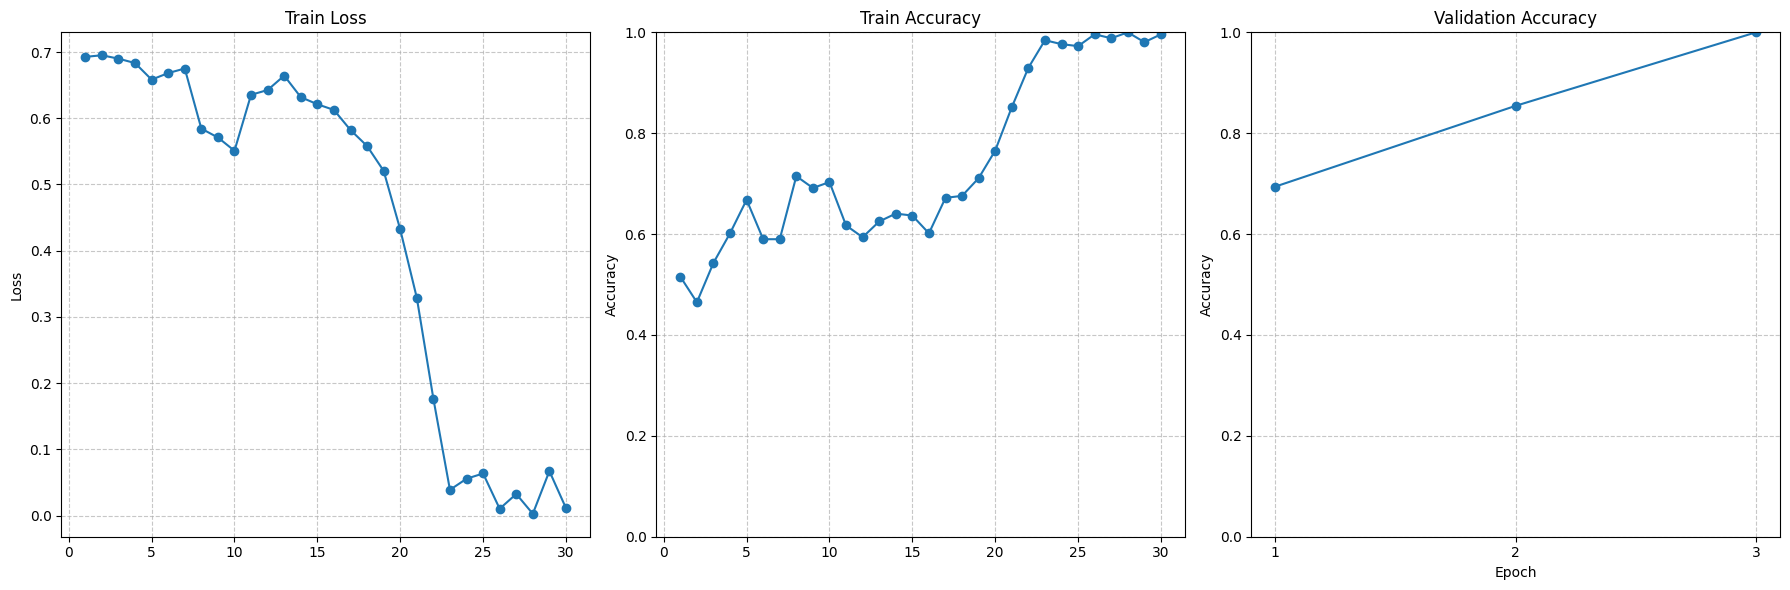

In [ ]:
# create an instance of the model
Bit_length = 8

model = Bit_wise_transformer(
      gpt2,
      bitLength = Bit_length,
      input_dim = 2,
      engine_embed_dim = 768,
).to(device)


# define the optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
num_epochs = 3

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Training loop
    running_loss = 0.0
    data_iterator = tqdm(train_loader)
    for i, (inputs, labels) in enumerate(data_iterator):
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs.view(-1, 2), labels.view(-1))
        accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())

        if (i + 1) % 50 == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device=device, dtype=torch.long)
          labels = labels.to(device=device, dtype=torch.long)
          outputs, _ = model(inputs)
          accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
          val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plot(losses, train_acc, all_val_acc)

torch.cuda.empty_cache()

##### (OPTIONAL) TODO: Interpret Attentinon Map
Visualize attention map for XOR task at different layer, feel free to change the $n\_layer$ argument.

See is there any pattern you can find in the attention map

(HINT: think about how the XOR string is computed)

Answer:

You may consider what is required to compute the output `c` for given two input bit strings, say `a` & `b`. The `i^th` bit of c is computed as `a[i] ^ b[i+len(input)]`. Therefore, at first few layers, attention should attend to `a[i]` and `b[i+len(input)]` at the same time. It is also interesting to see how the attention map evolves as going deeper through the network

In [ ]:
#@title visualize bit xor attention helper
def visualize_bitxor_attn(model, input_bits, n_layer=0):
  input_bits_t = torch.tensor(input_bits).type(torch.long)
  if len(input_bits_t.shape) < 2:
    input_bits_t = input_bits_t.unsqueeze(0)

  pred, attentions = model(input_bits_t.to(device))
  pred = torch.argmax(pred, dim=-1).squeeze(0).cpu().numpy()
  attentions = attentions[n_layer].squeeze(0)
  mean_attentions = attentions.mean(dim=0)
  mean_attentions = mean_attentions.detach().cpu().numpy()

  n_bit = int(input_bits_t.shape[-1]/2)
  plt.xlabel('Input Tokens', size=16)
  plt.xticks(range(n_bit * 2), input_bits)
  plt.ylabel('Output Tokens', size=16)
  plt.yticks(range(n_bit * 2), ['*'] * n_bit + list(pred))
  plt.title(f'attention map of layer {n_layer}')

  plt.imshow(mean_attentions)


correct out:  [1, 1, 1, 0, 0, 1, 1, 0]


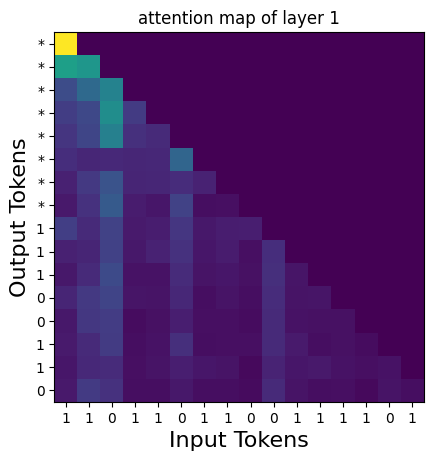

In [ ]:
input_bits = [
    1, 1, 0, 1, 1, 0, 1, 1,
    0, 0, 1, 1, 1, 1, 0, 1
]
ground_truth = [i ^ j for i, j in zip(input_bits[:8], input_bits[8:])]
print('correct out: ', ground_truth)
visualize_bitxor_attn(model, input_bits, n_layer=1)

#### Task 2: Bit Memory

In this part, we consider a bit memory task where the model is shown 5 bitstrings each of length 1000. Afterwards, the model is shown a masked version of one of the bitstrings, where each bit is masked with probability 0.5, and the model is tasked with producing the original bitstring from the model.

Example:
  
  5 bit input strings:
  ```
  [ 1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1  1  1 -1  1  1]
  [ 1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1]
  [-1 -1 -1  1  1  1  1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1]
  [-1 -1  1 -1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1]
  [ 1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1  1  1  1]
  ```

  random choose a query string (eg. 5th):
  ```
  [ 1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1  1  1  1]
  ```

  randomly masked(become 0) 50% of the bits:
  ```
  [ 0  0  0  1 -1 -1  0  0  0  0  0 -1  0  1  0  0  1  1]
  ```

  add the masked query string to the end of the input batch x:
  ```
  [ 1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1  1  1 -1  1  1]
  [ 1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1]
  [-1 -1 -1  1  1  1  1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1]
  [-1 -1  1 -1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1]
  [ 1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1  1  1  1]
  [ 0  0  0  1 -1 -1  0  0  0  0  0 -1  0  1  0  0  1  1]
  ```

  we want to predict the orignal query string y:
  ```
  [ 1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1  1  1  1]
  ```

Let's create dataset first.

TODO: implement the function that generate bit memory

In [ ]:
def generate_Bit_Memory(num_patterns, bit_length):
  '''
  1. Generate random bit patterns of shape (1, num_patterns, bit_length) with values in {0, 1}.
  2. Convert the values to {-1, 1}.
  3. Select a random index from the range [0, num_patterns) as the query index.
  4. Extract the bit pattern at the query index as the query bit pattern.
  5. Generate a mask of the same shape as the query bit pattern with all elements equal to 0 or 1 in 50 percent chance.
  6. Apply the mask to the query bit pattern to create the masked query bit pattern.
  7. Concatenate the original bit patterns and the masked query bit pattern along axis 1.
  8. Return the concatenated bit patterns (x) and the query bit pattern (y).

  Hint: the y is of shape [1, bit_length], x is of shape [1, num_patterns + 1, bit_length]
  '''

  ############################################################################
  # TODO: implement this part
  ############################################################################
  bits = np.random.randint(low=0, high=2, size=(1, num_patterns, bit_length))
  bits = 2 * bits - 1
  query_inds = np.random.randint(low=0, high=num_patterns, size=1)
  query_bits = bits[range(1), query_inds]
  mask = np.random.randint(low=0, high=2, size=query_bits.shape)
  masked_query_bits = mask * query_bits
  masked_query_bits = masked_query_bits.reshape(1, 1, bit_length)
  x = np.concatenate([bits, masked_query_bits], axis=1)
  y = query_bits

  return x, y

  ############################################################################

In [ ]:
test_generate_Bit_Memory()

All tests passed!


In [ ]:
class BitMemoryDataset(torch.utils.data.Dataset):
  def __init__(self,bit_length =1000, num_patterns=5, size = 100):
    self.bit_length = bit_length
    self.num_patterns = num_patterns
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    x,y = generate_Bit_Memory(self.num_patterns, self.bit_length)
    return torch.tensor(x, dtype=torch.float32).squeeze(), torch.tensor(y, dtype=torch.long).squeeze()



def generate_bit_memory_data_loaders(size = 100,bit_length = 1000, batch_size = 1, train_size=0.8):
  dataset = BitMemoryDataset(bit_length = bit_length, size=size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

As before, load the pretrained model and freeze necessary part.

In [ ]:
# load the GP2 model
gpt2 = GPT2Model.from_pretrained('gpt2')

In [ ]:
for name, param in gpt2.named_parameters():
# freeze all parameters except the layernorm and positional embeddings
  if 'ln' in name or 'wpe' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

Train the network using pretrained GPT2 model as universal computational engine. The model has:

*   An input embedding layer, which projects your input to accommodate GPT2 input demension

*   An output Linear layer and loss function

In [ ]:
class Bit_Memory_transformer(nn.Module):
  def __init__(self, engine,input_dim, engine_embed_dim, n_class, patch_size):

    super().__init__()
    self.input_dim = input_dim
    self.output_dim = n_class
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x):
        orig_dim = x.shape[-1]
        ratio = orig_dim // self.input_dim
        x = x.reshape(x.shape[0], x.shape[1] * ratio, self.input_dim)
        flattened_input = x.view(-1, 50)

        x = self.input_embed(flattened_input)
        x = self.engine(inputs_embeds = x.unsqueeze(0)).last_hidden_state
        x = x[:,-ratio:]
        x = self.output_layer(x)
        x = x.reshape(x.shape[0], x.shape[1] // ratio, ratio * self.output_dim)
        return x

In [ ]:
#@title Define the loss and accuacy function
ce_loss = torch.nn.CrossEntropyLoss()

def loss_fn(out, y, x=None, bit_length=1000):
    """
    Computes the cross-entropy loss for the model output.

    Args:
    - out: torch.Tensor, output tensor of shape (batch_size * sequence_length, n_class)
    - y: torch.Tensor, true labels tensor of shape (batch_size, sequence_length - bit_length)
    - x: torch.Tensor (optional), input tensor of shape (batch_size, sequence_length)
    - bit_length: int, length of the bit string (default: 1000)

    Returns:
    - loss: torch.Tensor, scalar value representing the cross-entropy loss
    """
    out = torch.reshape(out, (-1, bit_length, 2))
    ids = torch.zeros(y.shape).to(device=y.device).long()
    ids[y < 0], ids[y > 0] = 0, 1
    out, ids = torch.reshape(out, (-1, 2)), torch.reshape(ids, (-1,))
    return ce_loss(out, ids)

def accuracy_fn(preds, true, x=None, bit_length=1000):
    """
    Computes the accuracy for the model output.

    Args:
    - preds: numpy.ndarray, predicted labels tensor of shape (batch_size * sequence_length, n_class)
    - true: numpy.ndarray, true labels tensor of shape (batch_size, sequence_length - bit_length)
    - x: numpy.ndarray (optional), input tensor of shape (batch_size, sequence_length)
    - bit_length: int, length of the bit string (default: 1000)

    Returns:
    - accuracy: float, the mean accuracy of the predictions
    """
    preds = preds.reshape(-1, bit_length, 2).argmax(-1) * 2 - 1
    return (np.sign(preds) == np.sign(true)).mean()

def get_loss(x, y, bit_length, return_acc=True):
    """
    Computes the loss and accuracy for the model output.

    Args:
    - x: torch.Tensor, input tensor of shape (batch_size, sequence_length)
    - y: torch.Tensor, true labels tensor of shape (batch_size, sequence_length - bit_length)
    - bit_length: int, length of the bit string
    - return_acc: bool, whether to return the accuracy value (default: True)

    Returns:
    - loss: torch.Tensor, scalar value representing the cross-entropy loss
    - accs: float (optional), the mean accuracy of the predictions
    """
    out = model(x)
    loss = loss_fn(out, y, x=x, bit_length=bit_length)
    accs = accuracy_fn(
        out.detach().cpu().numpy(),
        y.detach().cpu().numpy(),
        x=x.detach().cpu().numpy(),
        bit_length=bit_length
    )
    return loss, accs

Define the Bit Memory model

In [ ]:
model = Bit_Memory_transformer(
    gpt2,
    input_dim = 50,
    engine_embed_dim = 768,
    n_class= 2*50,
    patch_size = 50
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

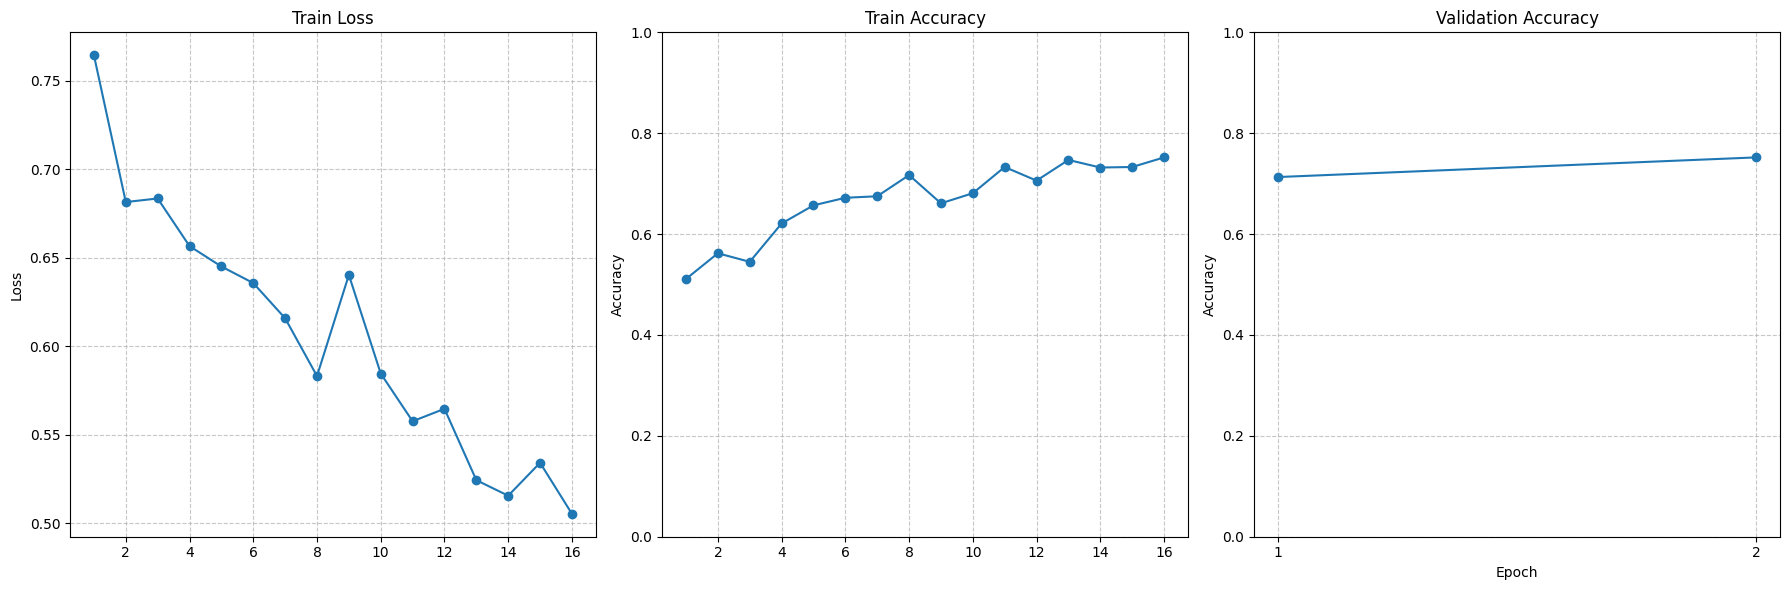

In [ ]:
bit_length = 1000
data_size = 100

train_loader, test_loader = generate_bit_memory_data_loaders(bit_length = bit_length, size = data_size, batch_size=1, train_size=0.8)

# define the optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
num_epochs = 2

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Training loop
    data_iterator = tqdm(train_loader)
    for i, (inputs, labels) in enumerate(data_iterator):
      loss, acc = get_loss(inputs, labels,bit_length, return_acc=True)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      data_iterator.set_postfix(loss=loss.item())

      if (i + 1) % 10 == 0:
            losses.append(loss.item())
            train_acc.append(acc.item())

    # validation loop
    val_acc = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loader:
        loss, acc = get_loss(inputs, labels,bit_length, return_acc=True)
        val_acc.append(acc.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plot(losses,train_acc,all_val_acc )

#### Task 3: Image classfication

For sure the previous task is quite simple and may not so convincing to show the generality of GPT-2. Now we move to a more complex domain, image classfication. We will do the task on the famous hand-written dataset MNIST and wish to reach a good result.

Still, we need to freeze some parameters in GPT-2 first.

In [ ]:
# A function freeze necessary parameters in GPT-2
def gpt2_freezer(
    model,
    freeze_param_list: List[str] = None
):
  for (name, param) in model.named_parameters():
    if freeze_param_list is not None:
      if any([k in name for k in freeze_param_list]):
        param.requires_grad = False
    else:
      param.requires_grad = False
  return model

In [ ]:
pretrained_gpt2 = GPT2Model.from_pretrained('gpt2')
gpt2_engine = gpt2_freezer(
    pretrained_gpt2,
    freeze_param_list = ["mlp", "attn", "wte"]
  )

To use GPT2 as the training engine, we need to convert input from other modality to accommodate GPT2 input. For image classification task in particular, we need to sequentialize image by patchifying it. If your implementation is correct, you should see the following

<div align="center"><img src="https://github.com/dibbla/dibbla.github.io/blob/main/a07d23e3e34acc11b32030d8b807eda.png?raw=true" width=40%/> </div>

Compared with traditional CNN, vision transformer style architecture injects less indutive bias in terms of the local structure of image. Another paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf) demonstrates extensively how we might deal with image tasks using transformer architecture. Feel free to refer to that.


TODO: patchify image

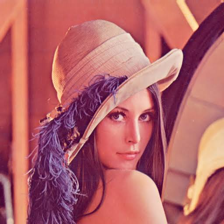

In [ ]:
def tensor2PIL(tensor: torch.Tensor):
    return transforms.ToPILImage()(tensor)

def display_patches(
    patches: torch.Tensor,
    n_patch: int
):

    fig, axes = plt.subplots(n_patch, n_patch)
    for i in range(n_patch):
        for j in range(n_patch):
            patch = patches[i*n_patch + j,:]
            axes[i][j].imshow(tensor2PIL(patch))
            axes[i][j].axis('off')

    plt.show()


def patchify(
    img: torch.Tensor,
    n_patch: int) -> torch.Tensor:

    ############################################################################
    # TODO: patchify image                                                     #
    ############################################################################
    '''
      HINT: use torch.Tensor.unfold()
      Args:
      - img: (batch, channel, height, width)
      - n_patch: you can assume that input image to be square
                 image will be patchified into (n_patch, n_patch) grid
    '''

    b, c, h, w = img.shape
    patch_h = h // n_patch
    patch_w = w // n_patch
    patches = img.unfold(-1, patch_h, patch_h) \
                 .permute(0, 3, 1, 4, 2) \
                 .unfold(-1, patch_w, patch_w) \
                 .permute(0, 4, 1, 2, 5, 3)
    patches = torch.reshape(patches, (b, n_patch * n_patch, c, patch_h, patch_w,))

    return patches
    ############################################################################
lenna = "https://i.stack.imgur.com/XKUT9.png"
img = Image.open(requests.get(lenna, stream=True).raw).resize((224, 224))
img

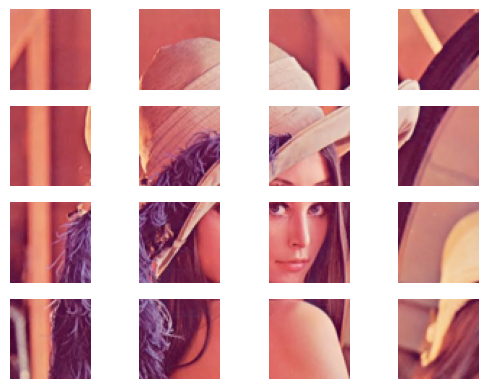

In [ ]:
# test if patchfy works correctly

transform = transforms.PILToTensor()
img = transform(img)
patches = patchify(img.unsqueeze(0), 4)
display_patches(patches[0], 4)

In [ ]:
#@title preprocessing code
img_size = (28, 28)
batch_size = 32
transform = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset = torchvision.datasets.MNIST('./data', train=True, download=True,
                    transform=transform)

train_val_split = 0.8
train_size = int(train_val_split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.MNIST('./data', train=False,
                      transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 317628854.22it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 17515282.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3297349.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20484439.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Now, it's time to design and train your own network using the pre-trained GPT-2 model as the main computational engine. You'll need to design:

- An input embedding layer, which projects your input to match the GPT-2 input dimension
- An output linear layer and a loss function

There are multiple ways to use a decoder-style network for classification tasks:

1. BERT-style <cls> token: Append a learnable embedding to extract classification information from the input patches. By appending instead of prepending, the <cls> token can accumulate information from the entire input sequence while maintaining the natural order of the input tokens. This makes it easier for the model to learn and understand the context. (Think about why appending instead of prepending)

2. Average output embedding: Average the output embeddings from the last layer across all input patches, and use this average as a feature representation for the input. This approach captures the overall semantic meaning of the input sequence and can be useful for classification tasks.

3. Last patch output embedding: Use only the output embedding from the last input patch as the feature representation for the input. This approach assumes that the last patch carries the most relevant information for classification.

TODO: For simplicity, we will choose option 3 for this task.

  

In [ ]:
class MNIST_clf(nn.Module):
  def __init__(self, engine, n_patch, input_dim, engine_embed_dim, n_class=10):

    '''
      Args:
      - n_patch: input image will be divided into (n_patch, n_patch) square patches
      - Engine: main computational engine used
      - input_dim: input dimension of the input linear projection layer
      - engine_embed_dim: embedding dimension used by the computational engine, eg. GPT2 uses 768
      - n_class: number of target class
    '''

    super().__init__()
    self.n_patch = n_patch
    self.input_flatten = nn.Flatten(start_dim=-3, end_dim=-1)
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.cls_token = nn.Parameter(torch.randn(1, 1, engine_embed_dim) * 0.02)
    self.engine = engine
    self.out = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x):
    '''
    step 1:
      implement input layer, which projects image patch into gpt2 embedding dimension

      After patchifying, images are converted to tensor of shape (bzs, patch_num, channel, patch_height, patch_width)
      TODO:
      - flatten out each patch
      - project patch to gpt2 input dimension

    step 2:
      use gpt2 pretrained model as the main computational engine to generate output embedding
      TODO:
      - feed into pretrained computational engine
      - extract output embedding from engine output
        recall that we are using paradigm-3 here: use embedding of last patch as output embedding

    step 3:
      implement output layer, which projects gpt2 output into output dimension for classification


    return value: tuple (prediction, attentions)
      - prediction: prediction obtained by model
      - attentions: attention map of engine  (batch_size, num_layer, num_head, seq_len)

    HINT: check hugging face documentation. https://huggingface.co/docs/transformers/model_doc/gpt2
    '''
    ############################################################################
    # TODO: implement forward pass of the model for visual task                #
    ############################################################################
    x = patchify(x, self.n_patch)
    embeds = F.relu(
        self.input_embed(self.input_flatten(x))
    )

    gpt2_output = self.engine(inputs_embeds=embeds, output_attentions=True)
    output = self.out(gpt2_output.last_hidden_state[:,-1])
    ############################################################################


    return output, gpt2_output.attentions


In [ ]:
#@title To help you better understand what happens in attention layer, here are some visualization functions.
def MNIST_unnormalize(x):
  return (x * 0.3081 + 0.1307) * 255


def logits_with_temp(logits, temp=0.2):
  '''
    Change the discrepancy of attention weight for visualization purpose
    smaller temperature corresponds to large discrepancy
  '''
  logits = torch.exp(logits/temp)
  logits = logits / torch.sum(logits)
  return logits


def visualize_attn_on_image(img, model):
  '''
      Visualize attention map at final layer, interpolate attention map into image size.
      Then mask it on the original image.

      Args:
      - img: normalized img
      - model: transformer model to obtain attention map for each layer

  '''
  # nifty way to check whether model is on cuda
  img = img.to(next(model.parameters()).device)

  with torch.no_grad():
    _, attentions = model(img.unsqueeze(0))

  attentions = torch.stack([attn.squeeze(0).mean(dim=0) for attn in attentions], dim=0).cpu()

  # accounting for residual connnection, then renormalize attention
  augmented_attn = attentions + torch.eye(attentions.shape[-1])
  augmented_attn = augmented_attn / augmented_attn.sum(dim=-1).unsqueeze(-1)

  mask = logits_with_temp(augmented_attn[-1,-1], 0.3) \
         .reshape(4, -1)

  mask = np.ascontiguousarray(
      (mask/mask.max()).detach().numpy()
  )
  mask = cv2.resize(mask, (28, 28))

  img = MNIST_unnormalize(
      img.squeeze(0).cpu().detach().numpy()
  )
  return (img * mask).astype('uint8')

def display_MNIST_with_attn(img_batch, model, img_size=(16,16)):
  '''
      visualzie batched data
  '''
  n = img_batch.shape[0]
  fig, axs = plt.subplots(nrows=n, ncols=2, figsize=img_size)

  axs[0, 0].set_title('Original')
  axs[0, 1].set_title('Attention Map')
  for i, img in enumerate(img_batch):

    attn_map = visualize_attn_on_image(
        img,
        model
    )
    img = MNIST_unnormalize(img).squeeze(0).cpu().numpy().astype('uint8')

    axs[i, 0].imshow(img)
    axs[i, 1].imshow(attn_map)
  fig.tight_layout()


First, we check how's the prediction result before training

In [ ]:
assert torch.cuda.is_available()
device = torch.device('cuda')
model = MNIST_clf(
    gpt2_engine,
    n_patch = 4,
    input_dim = 49,
    engine_embed_dim = 768
).to(device)

model = model.to(device)

acc = 0
model.eval()
for i, data in enumerate(test_dataloader):
  inputs, labels = data
  inputs = inputs.to(device); labels = labels.to(device)
  with torch.no_grad():
    pred, _ = model(inputs)
    acc += sum(pred.argmax(-1) == labels)

print("Accuracy: {:.2f}%".format(100 * acc/len(test_dataloader.dataset)))

Accuracy: 10.06%


Then, treat the GPT2 as a main computation engine and do the training

In [ ]:
assert torch.cuda.is_available()
device = torch.device("cuda")

n_epoch = 3

model = MNIST_clf(
    gpt2_engine,
    n_patch = 4,
    input_dim = 49,
    engine_embed_dim = 768
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
best_val_acc = .0

epoch_iterator = trange(n_epoch)
for epoch in epoch_iterator:
    data_iterator = tqdm(train_dataloader)

    # running_loss = 0.0

    # training loop
    model.train()
    for i, data in enumerate(data_iterator):
        inputs, labels = data
        inputs = inputs.to(device); labels = labels.to(device)

        optimizer.zero_grad()

        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())

    # validation loop
    acc = 0
    model.eval()
    for data in val_dataloader:
      inputs, labels = data
      inputs = inputs.to(device); labels = labels.to(device)
      with torch.no_grad():
        pred, _ = model(inputs)
        pred = torch.argmax(pred, dim=-1)
        acc += sum(pred == labels).detach().cpu()
    val_acc = acc / len(val_dataloader.dataset)

    if val_acc > best_val_acc:
      best_val_acc = val_acc

    epoch_iterator.set_postfix(val_acc = val_acc, best_val_acc = best_val_acc)




  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Tuning the parameters of the model to get at least 85% accuracy on test set

In [ ]:
# Test performance of model
acc = 0
model.eval()
for i, data in enumerate(test_dataloader):
  inputs, labels = data
  inputs = inputs.to(device); labels = labels.to(device)
  with torch.no_grad():
    pred, _ = model(inputs)
    acc += sum(pred.argmax(-1) == labels)

acc = acc/len(test_dataloader.dataset)

assert acc > .85

print("GPTvision test passed!")
print("Accuracy: {:.2f}%".format(100 * acc))


GPTvision test passed!
Accuracy: 0.01%


##### (OPTIONAL) TODO: Interpret Attention Map
In the attention-masked image, we visualize the attention weights by interpolating the attention matrix from the final layer to match the dimensions of the original image. This attention map is then overlaid on the input image, with brighter colors (e.g., yellow) indicating higher attention weights.

TODO: Think about why the attention map exhibits such pattern.

(HINT: how we use output from GPT2 to do classification)

Answers:

You are expected to see that most of the attention tends to be put on the last patch of the image. Recall that we extract the embedding of last patch returned by the engine as input to the final classifier. Therefore, the embedding of the last patch is responsible for aggregating information across the entire image as the input goes through the network. It is believable that at the final layer, the embedding of the last patch is the most important, i.e has the highest attention score.

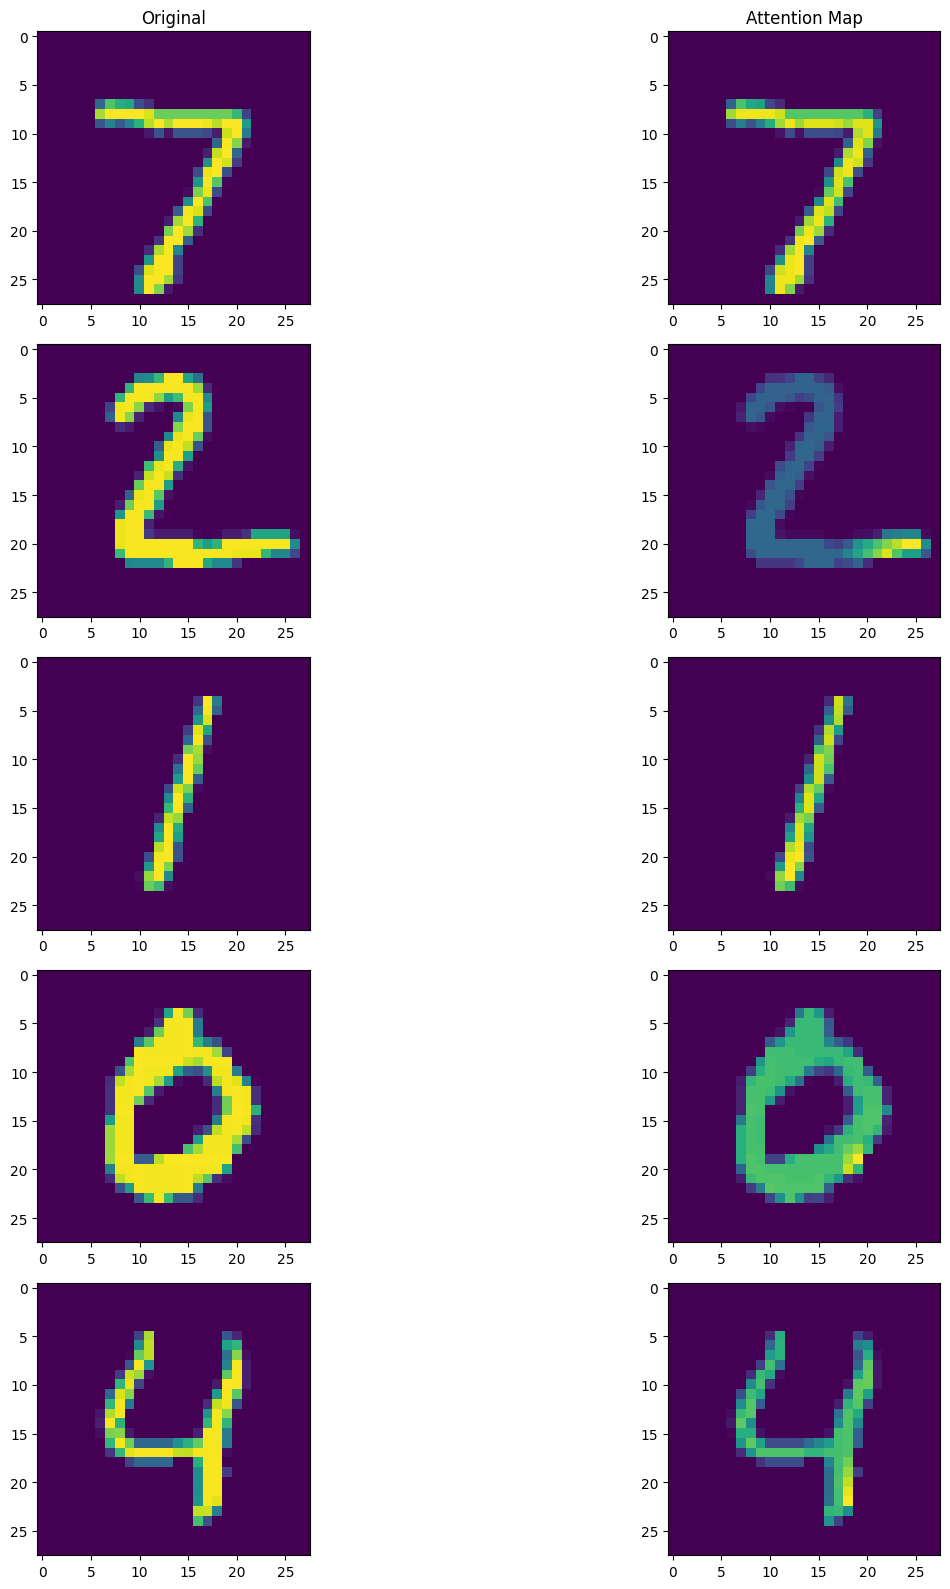

In [ ]:
batch_x, batch_y = next(iter(test_dataloader))
display_MNIST_with_attn(batch_x[:5], model)

### **Part 4: Advantages of Pre-trained Models: Speed and Accuracy**

In the previous section, we saw how GPT-2, pretrained on language tasks, can perform visual tasks. Now, we'll compare ResNet50 and fine-tuned GPT-2 on visual tasks in terms of training speed, accuracy, and parameter size.

ResNet50 is a pre-trained CNN designed for visual tasks, requiring fewer training epochs and having fewer parameters than GPT-2. In contrast, GPT-2 needs fine-tuning for visual tasks and has more parameters.

To compare their accuracy, we can use the MNIST dataset for image classification tasks and count each model's parameters.

Key differences:
- **ResNet50**: Tailored for visual tasks, faster training
- **Fine-tuned GPT-2**: Versatile but not designed for visual tasks

Comparing these models offers insights into trade-offs between specialized models like ResNet50 and adaptable models like GPT-2 for visual tasks, helping guide architecture choices for image classification problems.

In [ ]:
#@title Define dataset for ResNet-50
from torch.utils.data import DataLoader
# Rescale MNIST and make it 3 channel
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define dataloaders
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

We use pretrained ResNet-50 in the same spirit as what we did for the GPT-2. We only fine-tune the last layer of ResNet-50 on MNIST, and freeze other parameters.

In [ ]:
#@title Frozen, only train the last layer of ResNet-50.
res50_frozen = torchvision.models.resnet50(pretrained=True)
for param in res50_frozen.parameters():
    param.requires_grad = False
num_ftrs = res50_frozen.fc.in_features
res50_frozen.fc = nn.Linear(num_ftrs, 10)
res50_frozen.fc.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res50_frozen = res50_frozen.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


TODO: Tune the hyperparameters to get the best performance on the test set

In [ ]:
############################################################################
# TODO: Tune the hyperparameters to get the best performance on the test set
############################################################################
lr = 0.001
epoch = 2
criterion = nn.CrossEntropyLoss()
############################################################################
optimizer = optim.SGD(filter(lambda p: p.requires_grad, res50_frozen.parameters()), lr=lr, momentum=0.9)

# Train
for epoch in range(epoch):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        inputs, labels = data[0].to(device), data[1].to(device) # Move the data to the specified CUDA device
        optimizer.zero_grad()
        outputs = res50_frozen(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

print('Done')

# eval
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move the data to the specified CUDA device
        outputs = res50_frozen(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

assert (100 * correct / total) > 85

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Done
Accuracy on test set: 91 %


Here, we check the trainable parameter numbers of frozen resnet 50 and frozen GPT-2

In [ ]:
def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
print(get_parameter_number(res50_frozen))
print(get_parameter_number(model))

{'Total': 23528522, 'Trainable': 20490}
{'Total': 124486666, 'Trainable': 871690}


Our thoughts:

You might wonder why we'd choose to use GPT-2 with its larger training time and parameter count compared to ResNet-50. This can be explained by drawing an analogy with the idea of reduction in algorithm design. In some cases, we reduce simpler problems, like the independent set problem, to more complex problems, like integer linear programming. The rationale behind this is that the more complex problem has a sophisticated solver, which saves time and effort in designing an algorithm for the simpler problem.

Similarly, in the field of computer vision, we have well-designed models like ResNet-50. However, in some domains, there might not be specialized models available. In these cases, large language models like GPT-2 can be highly effective, saving time in designing domain-specific models. GPT-2's adaptability and versatility make it a valuable tool for tackling a wide range of problems beyond its original domain of language tasks.



### **Part 5: Influence of Model Capacity on Accuracy and Training Time**

In this section, we study how to model size will influence the accuracy and training time. We use small, medium and large GPT-2 for comparision. The training task is the bitwise operator you designed before.

In the tranning function below, we use the parameter `engine_name` to select different size model.

In [ ]:
#@title define the training function
import time
import pandas as pd
import matplotlib.pyplot as plt
import gc


def train(engine_name, train_loader, test_loader, Bit_length, num_epochs = 2):

  # create an instance of the model
  gpt2_engine = GPT2Model.from_pretrained(engine_name)
  for name, param in gpt2_engine.named_parameters():
    # freeze all parameters except the layernorm and positional embeddings
    if 'ln' in name or 'wpe' in name:
      param.requires_grad = True
    else:
      param.requires_grad = False


  # Choose the correct embedding size based on the GPT-2 model
  if engine_name == "gpt2":
      engine_embed_dim = 768
  elif engine_name == "gpt2-medium":
      engine_embed_dim = 1024
  elif engine_name == "gpt2-large":
      engine_embed_dim = 1280
  else:
      raise ValueError(f"Invalid model name: {engine_name}")

  model = Bit_wise_transformer(
      gpt2_engine,
      bitLength = Bit_length,
      input_dim = 2,
      engine_embed_dim = engine_embed_dim
  ).to(device)

  # define the optimizer and loss
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  losses = []
  train_acc = []
  all_val_acc = []
  best_val_acc = 0

  epoch_iterator = trange(num_epochs)
  for epoch in epoch_iterator:
      # Training loop
      running_loss = 0.0
      data_iterator = tqdm(train_loader)
      for i, (inputs, labels) in enumerate(data_iterator):
          optimizer.zero_grad()
          outputs, _ = model(inputs)
          loss = criterion(outputs.view(-1, 2), labels.view(-1))
          accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
          loss.backward()
          optimizer.step()

          data_iterator.set_postfix(loss=loss.item())

          if (i + 1) % 50 == 0:
              losses.append(loss.item())
              train_acc.append(accuracy.item())

      # Validation
      val_acc = []
      val_acc_10 = []
      model.eval()
      with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device=device, dtype=torch.long)
            labels = labels.to(device=device, dtype=torch.long)
            outputs, _ = model(inputs)
            accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
            val_acc.append(accuracy.item())
            val_acc_10.append(accuracy.item())
            if i % 10 == 0:
              all_val_acc.append(np.mean(val_acc_10))
              val_acc_10 = []
      model.train()

      # Save best model
      if np.mean(val_acc) > best_val_acc:
          best_val_acc = np.mean(val_acc)

      epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

  del model
  gc.collect()
  torch.cuda.empty_cache()
  return best_val_acc, all_val_acc

Here, we train with different model size and how accuracy changed with the size.

In [ ]:
engine_list = ["gpt2","gpt2-medium","gpt2-large"]

In [ ]:
# train the modified model
Bit_length = 8
Data_size = 20000

# training the model
train_loader, test_loader = generate_bit_wise_data_loaders(n=Bit_length, batch_size=32,data_size = Data_size, train_size=0.7)

results = []

for engine_name in engine_list:
  print("We are training the model engine: ", engine_name)
  start_time = time.time()
  best_val_acc, all_val_acc = train(engine_name, train_loader, test_loader, Bit_length, num_epochs = 1)
  train_time = time.time() - start_time
  #print("The best val accuracy using the model engine -- ", engine_name, ": ", best_val_acc)

  results.append({
        "model": engine_name,
        "val_acc_list":all_val_acc,
        "val_accuracy": best_val_acc,
        "train_time": train_time
    })


We are training the model engine:  gpt2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

We are training the model engine:  gpt2-medium


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

We are training the model engine:  gpt2-large


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

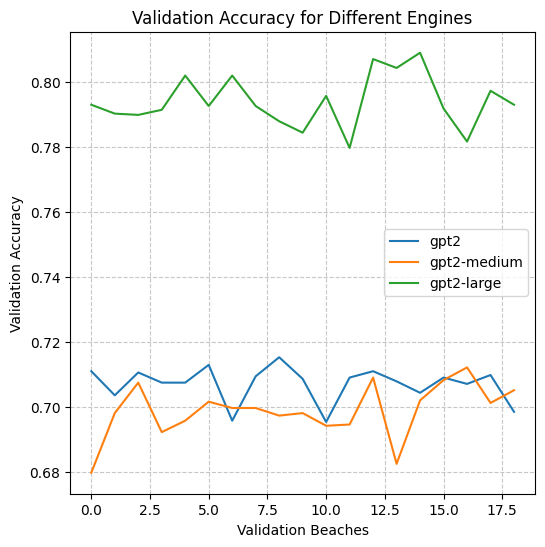

<Figure size 640x480 with 0 Axes>

In [ ]:
# Assuming your results list has been populated with the data from training
# and contains the "val_acc_list" for each engine

# Create a new figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
plt.figure()

# Loop through the results and plot the validation accuracy list for each engine
# ax.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
for result in results:
    engine_name = result["model"]
    val_acc_list = result["val_acc_list"]
    ax.plot(val_acc_list, label=engine_name)

# Set the title and labels for the plot
ax.set_title("Validation Accuracy for Different Engines")
ax.set_xlabel("Validation Beaches")
ax.set_ylabel("Validation Accuracy")

# Add a legend to show which line represents which engine
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

TODO: Describe what you see in the plot, did the model capacity have a significant affect on the accuracy? It is possible that using the same dataset to train different capacity models, such as GPT-2, GPT-2 medium, and GPT-2 large, might not always yield better performance with increasing capacity. What are the reasons of that?

*Hint: you can answer in the aspect of dataset size and complexity, overfitting, training time and resources, diminishing returns, and etc.*

Answers:

It is possible that using the same dataset to train different capacity models, such as GPT-2, GPT-2 medium, and GPT-2 large, might not always yield better performance with increasing capacity. There could be a few reasons for this:

1. **Dataset size and complexity**: If the dataset used for training is small or not complex enough, a larger capacity model may not have the opportunity to fully utilize its capacity, leading to no significant improvement in performance. In such cases, a smaller model may already be sufficient to capture the underlying patterns in the dataset.

2. **Overfitting**: A larger capacity model has more parameters and, therefore, a higher chance of overfitting to the training dataset, especially if the dataset is small. Overfitting can lead to poor generalization performance when evaluating the model on new, unseen data.

3. **Training time and resources**: Larger capacity models require more time and computational resources to train. If the training is not adequately optimized or if the model is not trained for a sufficient number of epochs, the larger model may not fully converge, resulting in suboptimal performance compared to smaller models.

4. **Diminishing returns**: There is a point of diminishing returns when increasing the capacity of a model. As model capacity increases, the performance improvements may become smaller and eventually plateau. In some cases, the performance may even degrade slightly due to overfitting or other factors.

It is essential to consider these factors when training and evaluating models of different capacities. You may need to adjust the dataset size or complexity, apply regularization techniques to counter overfitting, or optimize training hyperparameters to achieve better results with larger models. Additionally, always keep in mind the trade-offs between model capacity, training time, and computational resources when choosing the right model for your task.